# Tutorials #1: Environments Descriptions

## Grid map generation

The goal of this notebook is to explain environment definitions in this repository. The map to be used for motion planning is represented as discrete grid map defined as `GridMap` class. We can easily set geometry and apperance information into the map using `TerrainGeometry` and `TerrainColoring` classes.

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from environments.grid_map import GridMap
from environments.grid_map import TerrainGeometry
from environments.grid_map import TerrainColoring

sns.set()

1. Initialize `GridMap` with the prefereble size of grid `grid_size` and grid resolution [m] `resolution`. You can also provide `seed` if you want to maintain reproductivity.

In [2]:
grid_map = GridMap(
    grid_size=64,  # 64x64 grid
    resolution=0.5,  # 0.5m per grid
    seed=0,  # random seed
)

2. Call `TerrainGeometry` in order to set geometrical information into the grid map. If you want to create just a random height environment, you can set `is_fractal = True` and `is_crater = False` . If you want to create an environment having crater-like geometry, you can set `is_crater = True`. In order to generate crater, you can tune the number of craters as well as those characteristics, such as the size and slope magnitude. However, if the parameters do not fit the grid map, the crater generation procedure ends in the middle.

In [3]:
terrain_geometry = TerrainGeometry(grid_map=grid_map)
terrain_geometry.set_terrain_geometry(
    is_fractal=True,  # fractal terrain
    is_crater=True,  # with crater
)

3. Call `TerrainColoring` in order to set appearance inoformation into the grid map. What you need to create color map is `occupancy` defining occupancy ratios for different terrain classes.

In [4]:
terrain_coloring = TerrainColoring(grid_map=grid_map)
terrain_coloring.set_terrain_class_coloring(
    occupancy=torch.tensor([0.4, 0.4, 0.1, 0.1])  # 40% of #1, 40% of #2, 10% of #3, 10% of #4 terrain classes
)

That is it! You have now created a grid map with fractal terrain and colored it with the specified terrain classes.
More specifically, you can access `tensor_data` attribute in `GridMap` class and it contains the following information.
- heigths: A 2D tensor representing the terrain height map in [m].
- slopes: A 2D tensor representing the terrain slope values in [deg].
- colors: A 3D tensor (3 x height x width) representing RGB color values.
- t_classes: A 2D tensor representing terrain classes for every pixel.

### Visualized examples of terrain geometry

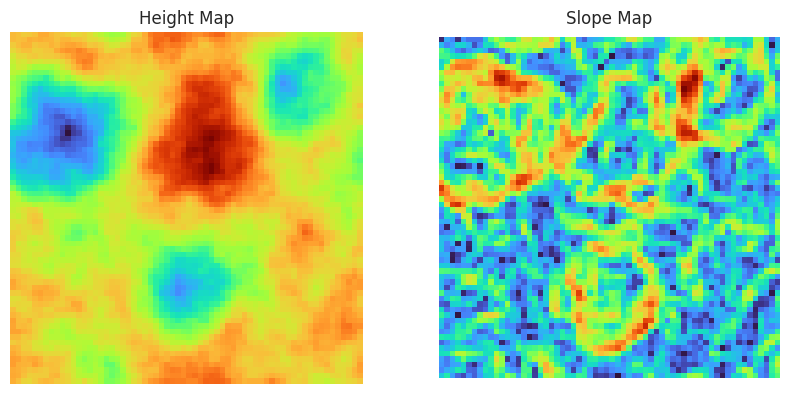

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# height map
axs[0].imshow(grid_map.tensor_data["heights"].cpu().numpy(), cmap="turbo")
axs[0].set_title("Height Map")
axs[0].axis("off")

# slope map
axs[1].imshow(grid_map.tensor_data["slopes"].cpu().numpy(), cmap="turbo")
axs[1].set_title("Slope Map")
axs[1].axis("off")

plt.show()

## Visualized examples of terrain coloring

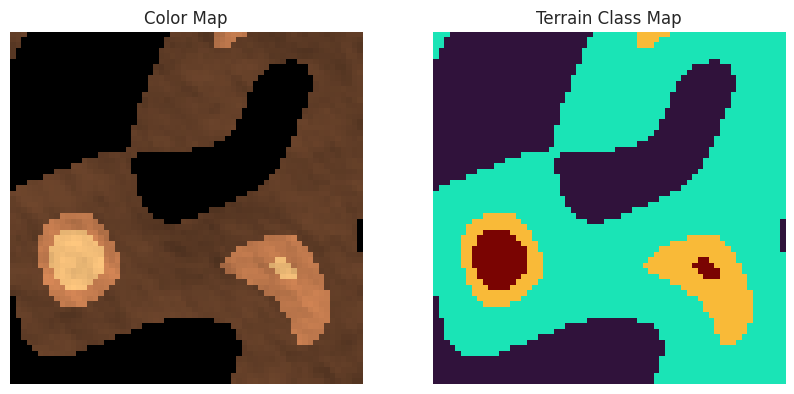

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# height map
axs[0].imshow(grid_map.tensor_data["colors"].cpu().numpy().transpose(1, 2, 0))
axs[0].set_title("Color Map")
axs[0].axis("off")

# slope map
axs[1].imshow(grid_map.tensor_data["t_classes"].cpu().numpy(), cmap="turbo")
axs[1].set_title("Terrain Class Map")
axs[1].axis("off")

plt.show()

## Slip Model Generation
Now you can see the environment represented as `GridMap` has diverse geometry and appearance inforamtion. We further assign latent slip models for each terrain classes. The assumption is as follows:
- Each terrain class has a single latent slip model.
- Slip model takes slope [deg] input and outputs slip ratio $s$ ($-1 < s < 1$). If $|s| \geq 1$, the robot cannot move any more (permanent robot entrapment).

Based on the above settings, we define the `SlipModel` class to project terrain geometry into traversability for assigned terrain classes.

In [7]:
from src.environments.slip_model import SlipModel

1. Initialize `SlipModel`. You can provide hyper-parameters for the latent slip models in order tune its steepness.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SlipModel(
    device=device,
    slip_sensitivity=1.0,  # sensitivity of slip to slope
    slip_nonlinearity=2.0,  # nonlinearity of slip to slope
    slip_offset=0.1,  # offset of slip at zero slope
    base_noise_scale=0.1,  # noise scales
)

2. Obtain slip observation results for slope angle inputs.

In [9]:
phis = torch.linspace(-30, 30, 500).to(device)  # slope angles from -30 to 30 degrees
slips = model.observe_slip(phis)  # observe slip for the given slope angles

That is it! You can see how the slip changes with the slope angle.

## Visualized examples of latent slip model 

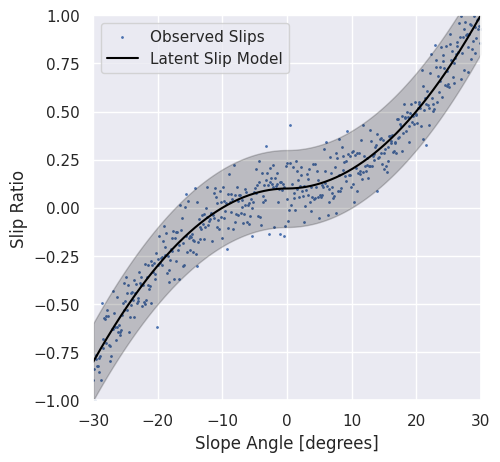

In [10]:
# retrieve noise-free slip model
reference_slips = model.latent_model(phis)
# retrieve noise scales for the given slope angles
noise_scales = model.noise_model(phis)
lowers = reference_slips - noise_scales * 2
uppers = reference_slips + noise_scales * 2

# plot slip model
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(phis.cpu().numpy(), slips.cpu().numpy(), s=1, label="Observed Slips")
ax.plot(
    phis.cpu().numpy(),
    reference_slips.cpu().numpy(),
    label="Latent Slip Model",
    color="black",
)
ax.fill_between(
    phis.cpu().numpy(),
    lowers.cpu().numpy(),
    uppers.cpu().numpy(),
    alpha=0.2,
    color="black",
)
ax.set_xlabel("Slope Angle [degrees]")
ax.set_ylabel("Slip Ratio")
ax.set_xlim(-30, 30)
ax.set_ylim(-1, 1)
ax.grid(True)
ax.legend()

plt.show()